In [1]:
# 10/03/2022 Luís

# This model will be trained with data generated by the script "generate_HGO_noise".
# The data set contains 10^6 curves.

# The model predicts the absolute coordinates of each data point

# The Huber loss function will be used.

# This approach has given in worse results, when compared to its counterparts 
# which predict differences between successive data points.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import ast
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd
import random

import sympy as sym
from sympy.physics.quantum import TensorProduct

import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [4]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [5]:
X = np.load('X_run_10_noise.npy')
y = np.load('y_run_10_noise.npy')

In [6]:
ninc = np.shape(y)[1]

In [7]:
#the code below should be in a separate file. it's is important to keep data generator separated from model training

#training script should start by loading X and y

#let's save 10% of the data for testing. these curves won't be part of the model training 
test_split=0.1
x_train, x_test,y_train,y_test = train_test_split(X, y, test_size = test_split)
#let's check the array shapes: 
print('Input data')
print('Training set: ',x_train.shape)
print('Test set: ',x_test.shape)
print(' ')
print('Features')
print('Training set: ',y_train.shape)
print('Test set: ',y_test.shape)
#train_size = train_df.shape[0]
#test_size = test_df.shape[0]

#reshape for keras training
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 2))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 2))
#shuffle data
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]


Input data
Training set:  (90000, 5)
Test set:  (10000, 5)
 
Features
Training set:  (90000, 10, 2)
Test set:  (10000, 10, 2)


In [8]:
np.shape(x_train)

(90000, 5)

In [9]:
np.shape(y_train)

(90000, 10, 2)

In [22]:
# Set the hyperparameters
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.0004
BATCH_SIZE = 128
EPOCHS = 80
INPUT_SHAPE = x_train.shape[1:]
OUTPUT_SHAPE = y_train.shape[1:]


inputs = keras.Input(shape=INPUT_SHAPE)

dense = layers.Dense(4 * ninc, activation="relu")
x = dense(inputs)

dense = layers.Dense(10 * ninc, activation="relu")
x = dense(x)

x = tf.keras.layers.Reshape((ninc, -1))(x)

x = layers.Dense(128, activation="relu")(x)

x = layers.Dense(64, activation="relu")(x)

dropout = tf.keras.layers.Dropout(0.05)
x = dropout(x)

outputs = layers.Dense(2)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="model")

model.compile(
    #loss="mean_squared_error",
    loss = tf.keras.losses.Huber(),
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    #optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay = LEARNING_RATE/EPOCHS),
    metrics=["mean_squared_error"],
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 40)                240       
_________________________________________________________________
dense_16 (Dense)             (None, 100)               4100      
_________________________________________________________________
reshape_3 (Reshape)          (None, 10, 10)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 10, 128)           1408      
_________________________________________________________________
dense_18 (Dense)             (None, 10, 64)            8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 64)            0     

In [23]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    x_train,
    y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

Epoch 1/80
563/563 [==============================] - 4s 6ms/step - loss: 5.5297 - mean_squared_error: 38092.3711 - val_loss: 4.0854 - val_mean_squared_error: 26729.6992
Epoch 2/80
563/563 [==============================] - 3s 5ms/step - loss: 4.5411 - mean_squared_error: 37947.0469 - val_loss: 4.0254 - val_mean_squared_error: 26647.1504
Epoch 3/80
563/563 [==============================] - 3s 5ms/step - loss: 4.4793 - mean_squared_error: 37889.9414 - val_loss: 3.9951 - val_mean_squared_error: 26600.3008
Epoch 4/80
563/563 [==============================] - 3s 5ms/step - loss: 4.4149 - mean_squared_error: 37827.7500 - val_loss: 3.9048 - val_mean_squared_error: 26530.7051
Epoch 5/80
563/563 [==============================] - 3s 5ms/step - loss: 4.3014 - mean_squared_error: 37688.3242 - val_loss: 3.7677 - val_mean_squared_error: 26337.1387
Epoch 6/80
563/563 [==============================] - 3s 6ms/step - loss: 4.1062 - mean_squared_error: 37348.3281 - val_loss: 3.5505 - val_mean_square

3.9058069586753845


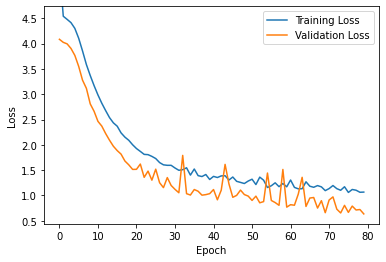

In [24]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [25]:
def plot_curves(k):

    x_predict = np.zeros(ninc)
    y_predict = np.zeros(ninc)

    c = 0
    for i in model.predict(x_test[k:k+1])[0]:
        x_predict[c] = i[0]
        y_predict[c] = i[1]
        c = c+1

    x_true = np.zeros(ninc)
    y_true = np.zeros(ninc)

    c = 0
    for i in y_test[k:k+1][0]:
        x_true[c] = i[0]
        y_true[c] = i[1]
        c = c+1

    plt.plot(x_predict,y_predict, "--",  color = "r", label = "prediction")

    plt.plot(x_true,y_true, color = "g", label = "real")

    plt.legend()
    plt.show()

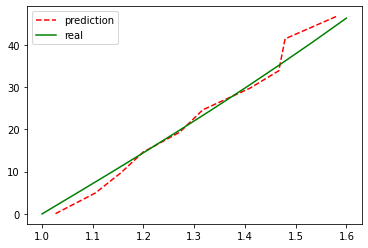

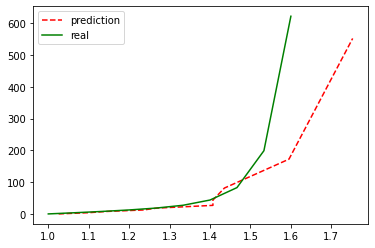

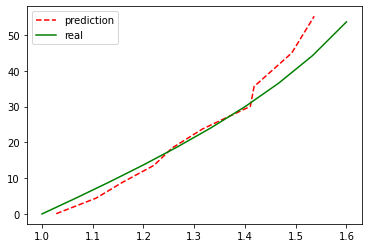

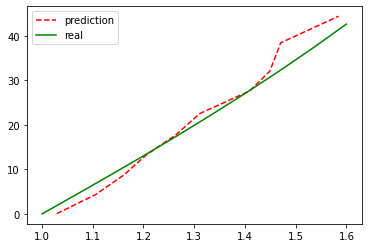

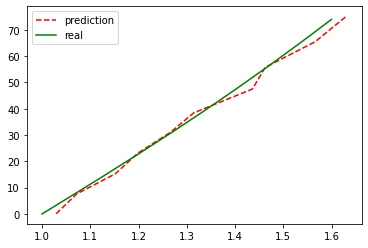

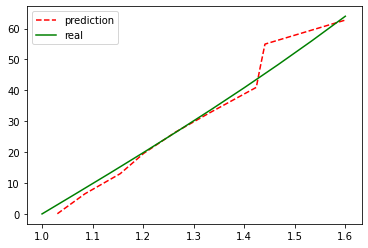

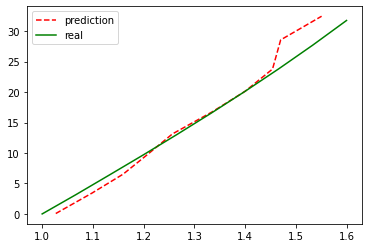

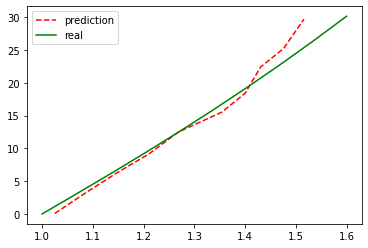

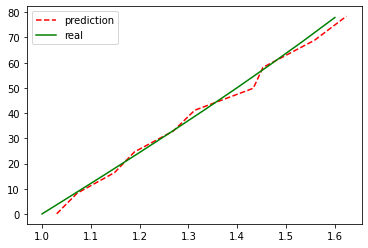

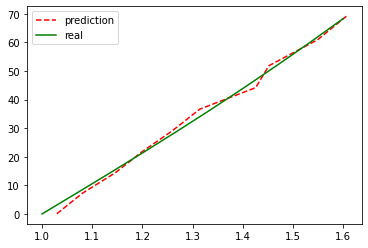

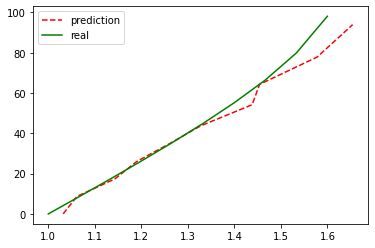

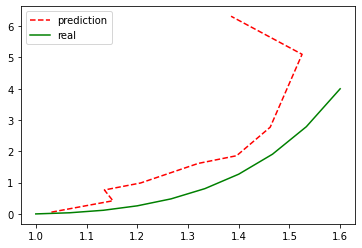

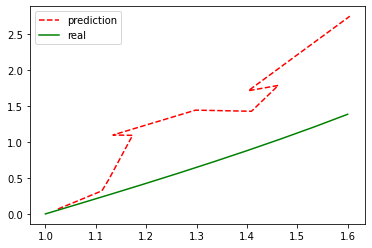

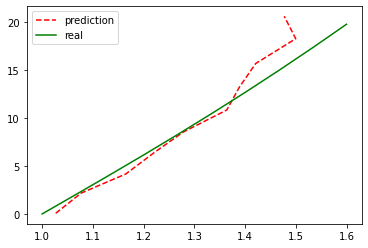

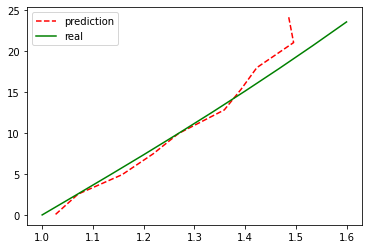

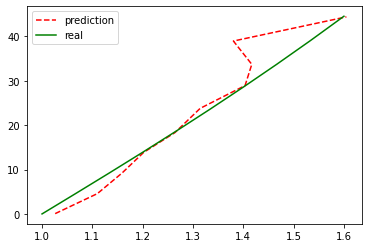

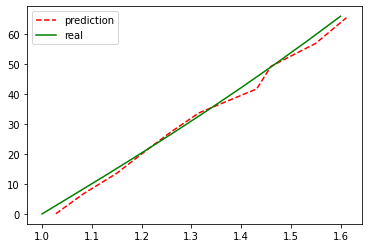

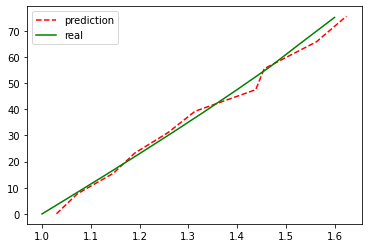

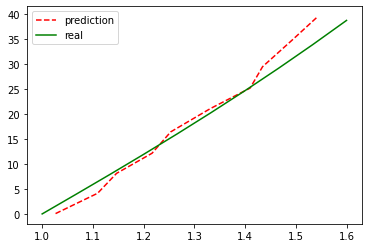

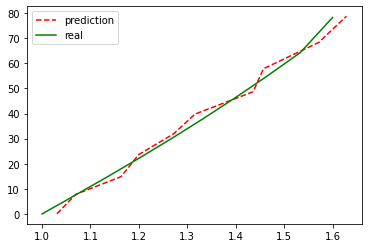

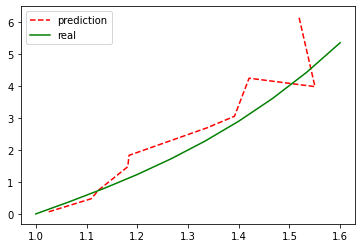

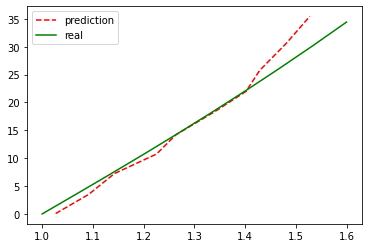

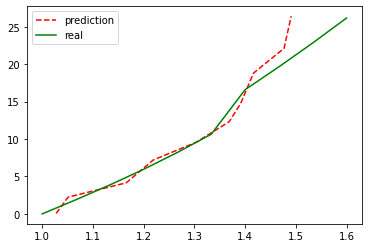

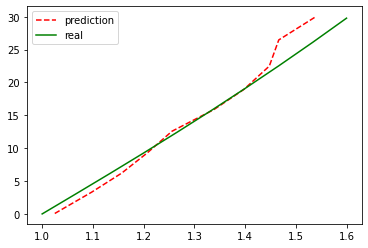

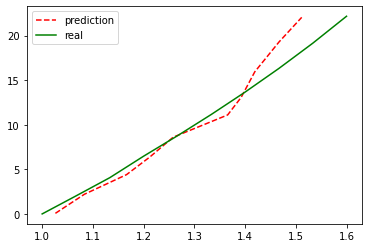

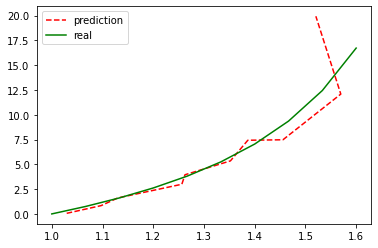

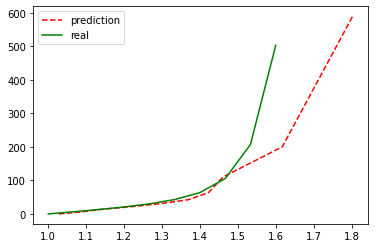

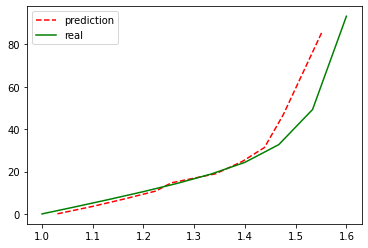

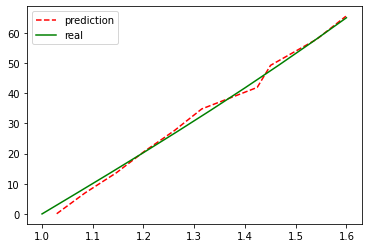

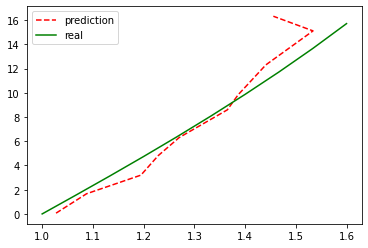

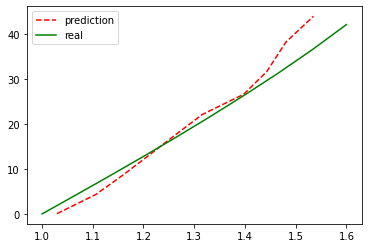

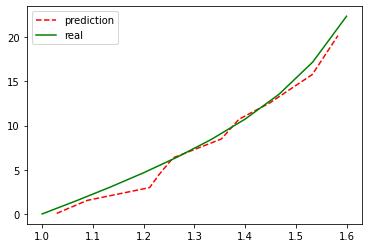

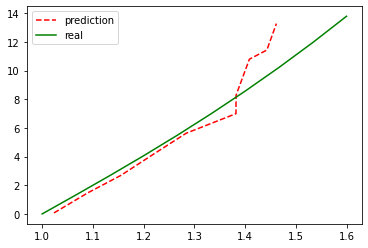

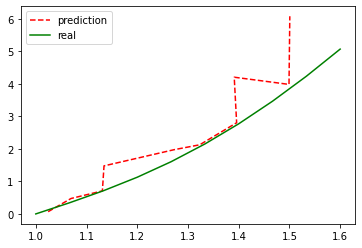

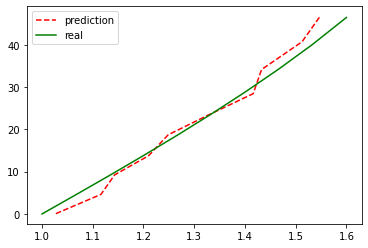

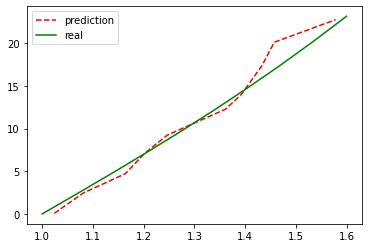

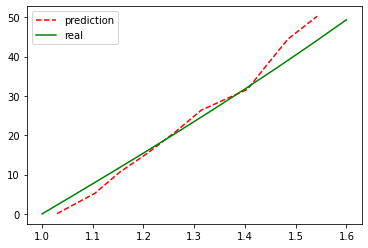

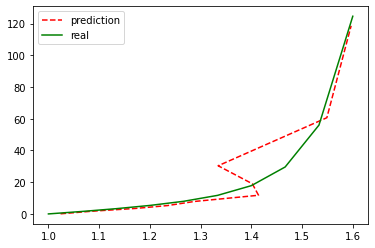

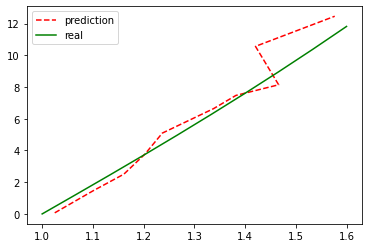

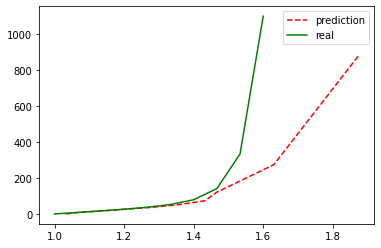

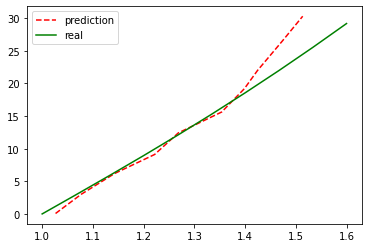

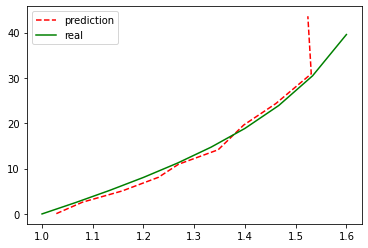

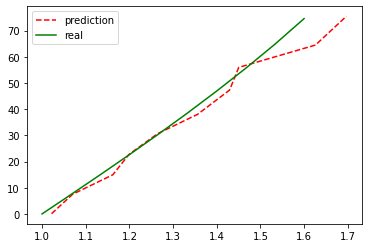

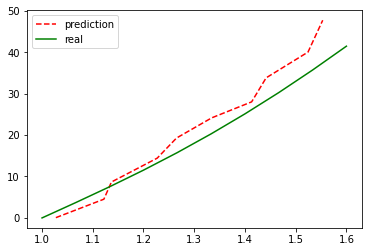

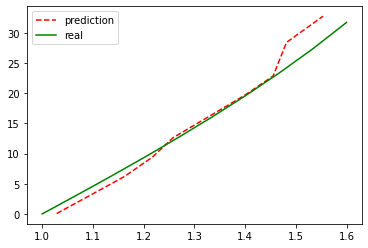

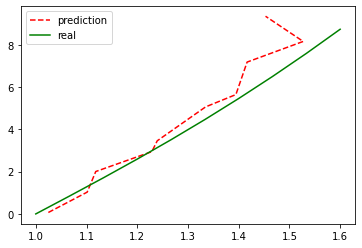

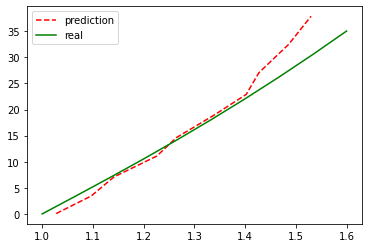

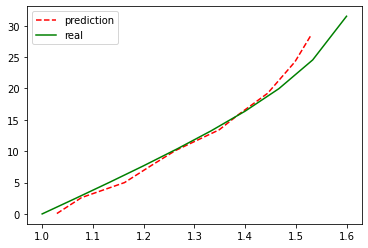

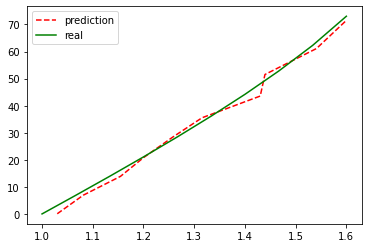

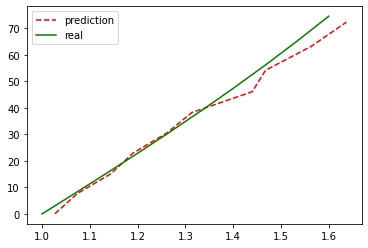

In [26]:
for i in range(50): plot_curves(i)